In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
import yfinance as yf
import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

In [4]:
stock_data = yf.Ticker("AAPL")
stock_data.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '(408) 996-1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and p

In [5]:
# Extract the data for the last year 
df = stock_data.history(period="2y", interval="1d")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-11-23 00:00:00-05:00,147.894743,150.249980,147.785887,149.497894,58301400,0.0,0.0
2022-11-25 00:00:00-05:00,146.766611,147.330686,145.588992,146.568695,35195900,0.0,0.0
2022-11-28 00:00:00-05:00,143.629617,145.114007,141.887937,142.719193,69246000,0.0,0.0
2022-11-29 00:00:00-05:00,142.788455,143.303048,138.889469,139.700928,83763800,0.0,0.0
2022-11-30 00:00:00-05:00,139.928522,147.172354,139.087377,146.489532,111380900,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-18 00:00:00-05:00,225.250000,229.740005,225.169998,228.020004,44686000,0.0,0.0
2024-11-19 00:00:00-05:00,226.979996,230.160004,226.660004,228.279999,36211800,0.0,0.0
2024-11-20 00:00:00-05:00,228.059998,229.929993,225.889999,229.000000,35169600,0.0,0.0


In [13]:
# Let us create a Series for the column we want to work on
y = df[['Close']]
print("y type", type(y))
y.head()

y type <class 'pandas.core.frame.DataFrame'>


,Close
Date,
2022-11-23 00:00:00-05:00,149.497894
2022-11-25 00:00:00-05:00,146.568695
2022-11-28 00:00:00-05:00,142.719193
2022-11-29 00:00:00-05:00,139.700928
2022-11-30 00:00:00-05:00,146.489532


In [14]:
y.isnull().sum()

Close    0
dtype: int64

In [15]:
# Change the frequency to day
y = y.asfreq('D', method="ffill")

In [16]:
y.shape

(731, 1)

In [17]:
# Fill missing values
y = y.ffill()

In [18]:
y

,Close
Date,
2022-11-23 00:00:00-05:00,149.497894
2022-11-24 00:00:00-05:00,149.497894
2022-11-25 00:00:00-05:00,146.568695
2022-11-26 00:00:00-05:00,146.568695
2022-11-27 00:00:00-05:00,146.568695
...,...
2024-11-18 00:00:00-05:00,228.020004
2024-11-19 00:00:00-05:00,228.279999
2024-11-20 00:00:00-05:00,229.000000


In [19]:
# Split the data into training and test datasets
train_df = y.iloc[:int(len(y)* 0.8) + 1]
test_df = y.iloc[int(len(y) * 0.8):]


In [26]:
# Tuning hyperparameters
p_params = range(0, 300, 50)

forecast_results = {}

for lag in p_params:
    # Fit model with the current lag
    model = AutoReg(train_df['Close'] ,lags=lag).fit(cov_type="HC0")
    
    # Predict values for the test set
    predictions = model.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=True)
    
    # Predict 90 days
    forecast_end = test_df.index[-1] + dt.timedelta(days=90)
    forecast = model.predict(start=test_df.index[0], end=forecast_end, dynamic=True)

    mae = mean_absolute_error(test_df, predictions)

    forecast_results[lag] = forecast

    print(mae)
    



51.899672702035424
28.647181617794693
37.46616835401286
45.7935594616428
47.47158086474294
48.30998770309719


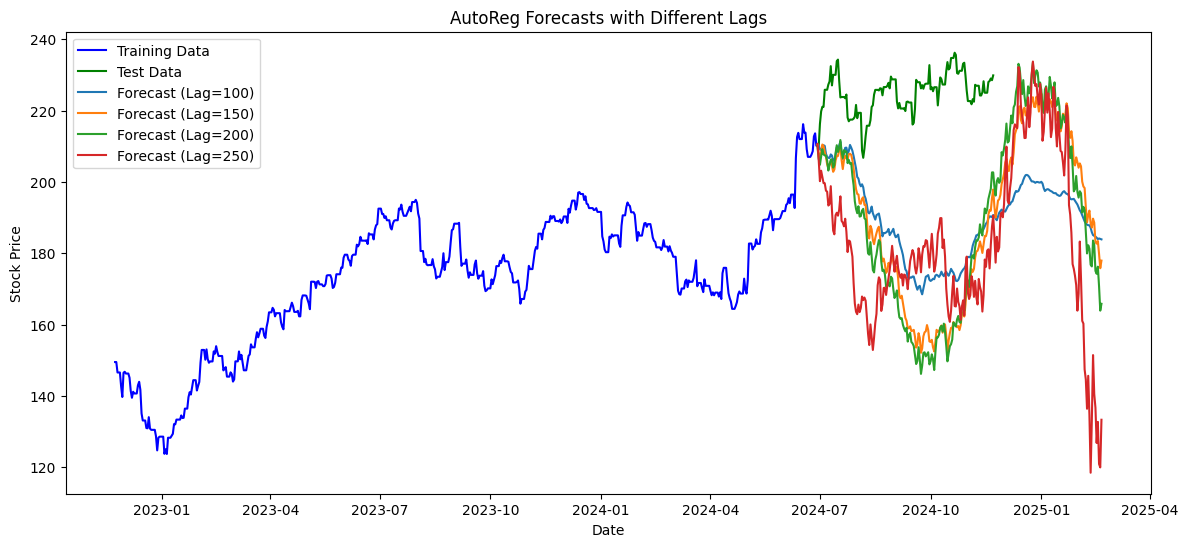

In [23]:
plt.figure(figsize=(14, 6))

# Plot the original training and test data
plt.plot(train_df.index, train_df['Close'], label='Training Data', color='blue')
plt.plot(test_df.index, test_df['Close'], label='Test Data', color='green')

# Plot the forecast for each lag
for lag, forecast in forecast_results.items():
    plt.plot(forecast.index, forecast, label=f'Forecast (Lag={lag})')

plt.legend()
plt.title("AutoReg Forecasts with Different Lags")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

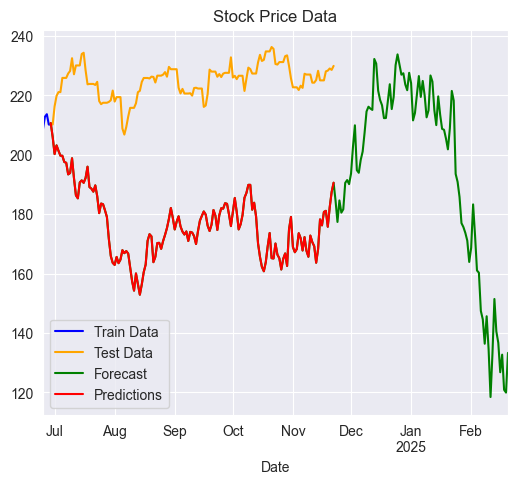

In [28]:

model = AutoReg(train_df['Close'], 250).fit(cov_type="HC0")
# Predict data for test data
predictions = model.predict(start=test_df.index[0], end=test_df.index[-1], dynamic=True)

# Predict 90 days into the future
forecast = model.predict(start=test_df.index[0], end=test_df.index[-1]+dt.timedelta(days=90), dynamic=True)

# View the forecasted values
sns.set_style('darkgrid')

# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()

# Default figure size
sns.mpl.rc('figure',figsize=(6, 5))

# Set fig and ax
fig, ax = plt.subplots()

# Plot the data
ax = train_df.tail(5).plot(ax=ax, color='blue')
ax = test_df.plot(ax=ax, color='orange')
ax = forecast.plot(ax=ax, color='green')
ax = predictions.plot(ax=ax, color='red')

# Customize the plot
plt.legend(["Train Data", "Test Data", "Forecast", "Predictions"])
plt.title("Stock Price Data")

# Show the plot
plt.show()